# Linear regression model with variance based feature selection

In [24]:
# import necessary packages

# Plot the figures inline, necessary only for Jupyter notebook
%matplotlib inline 

import os # miscelleaneous operating system interface
import numpy as np  # import numpy
import pandas as pd # import pandas
import matplotlib.pyplot as plt 
import seaborn as sns # import seaborn for data visualization

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error as RMSE # calculate RMSE
from sklearn.pipeline import Pipeline # may need it later for feature engineering
from sklearn.model_selection import train_test_split # splitting data into training and testing set

In [25]:
# import the data set for drugs

df_drug=pd.read_csv('GDSC2_label_14drugs.csv') # load the data set for drugs (limited to 14 drugs)
df_drug.set_index('Unnamed: 0', inplace=True)

# print(df_drug.shape) # shape for drug data

# Result: 805 tumor cells (cell lines) and 14 drugs
# df_drug.head(5) # print the first 5 instances to have a look

# We only focus on the 3 drugs with largest variances in their efficacies among different drugs
drug_sort=df_drug.std().sort_values(ascending = False).iloc[0:3]

# import the data set for tumor cells (cell lines) and genes

df_tumor=pd.read_csv('GDSC2_expression14.csv') # load the data set for tumors and cell lines
df_tumor.set_index('Unnamed: 0', inplace=True)
gene=list(df_tumor.columns)

# print('Number of genes:', len(gene))
# print('First gene: ',gene[0])

# print('Shape of data frame', df_tumor.shape) # shape for tumor data
# df_tumor.iloc[0:5, 0:10] # print the first 5 instances to have a look, only print the first 10 columns

# Result: 805 tumor cells (instances) and 17419 genes (features)

In [26]:
# The 3 drugs with the largest variances among all 805 tumors
# See EDA and overfitting notebook

drug1=drug_sort.index[0] # 'Docetaxel'
drug2=drug_sort.index[1] # 'Trametinib'
drug3=drug_sort.index[2] # 'Entinostat'

# Merge the two data set together WITHOUT any selection of features
# We do not need to save too many decimal places, keep 2 decimal places is fine
# The last column becomes the drug efficacy

df_1=pd.concat([df_tumor, df_drug[drug1].round(2)], axis=1) # axis=1 because we join the columns, not rows
df_2=pd.concat([df_tumor, df_drug[drug2].round(2)], axis=1) 
df_3=pd.concat([df_tumor, df_drug[drug3].round(2)], axis=1) 

# print(df_1.shape)
# df_1.head(5)

# Linear regression model with 20 most variate genes

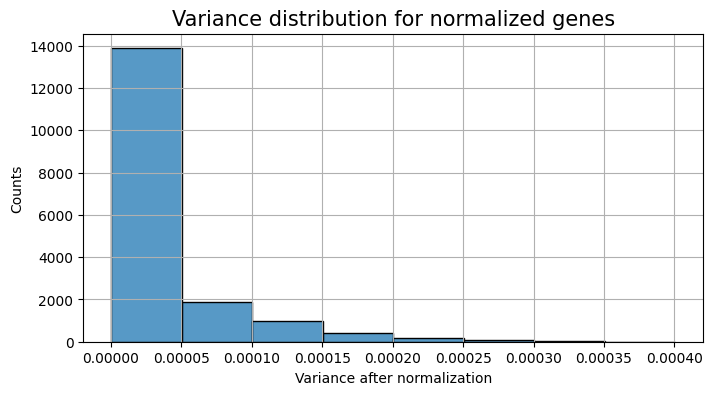

Index(['RPS4Y1', 'HLA-DRA', 'ITM2A', 'MIR205HG', 'TACSTD2', 'SPP1', 'TSPAN8',
       'LAPTM5', 'TFF1', 'GMFG', 'COL1A2', 'KRT6A', 'LUM', 'S100A9', 'BEX1',
       'SRGN', 'CD53', 'IGJ', 'POU2AF1', 'S100A14'],
      dtype='object')

In [27]:
# Calculate variance for each gene across the 805 samples
# Select the 20 genes with highest variance (after normalization)

from sklearn.preprocessing import normalize # normalize the columns for the genes

n=20 # number of genes to keep

df_tumor_norm=pd.DataFrame(normalize(df_tumor, axis=0)) # result after normalization is a numpy array, we need data frame
df_tumor_norm.columns=gene # assign the gene name as column names

# calculate the variance for each gene type across 805 samples and sort the results
df_tumor_var=pd.DataFrame(df_tumor_norm.var())
df_tumor_var.columns=['normed var']

# Plot the distribution of variances for genes after normalization
fig, ax = plt.subplots(figsize = (8,4)) 
  
sns.histplot(data=df_tumor_var, x="normed var",binwidth=0.00005)
ax.set_xlabel( "Variance after normalization" , size = 10) 
ax.set_ylabel( "Counts" , size = 10) 
ax.set_title( "Variance distribution for normalized genes", size = 15) 
plt.grid()
plt.show() 

# Comments: There are many genes having small variances across different types of tumor cells. 
# Again, doesn't mean that they have no importance in drug efficacy!

# Picking the 20 genes with the largest variances across all tumor types

df_var=df_tumor_var.sort_values('normed var',ascending = False).iloc[0:n,:]
df_var.index # This list stores the names of that 20 genes
# df_var

In [28]:
# Using the selected genes from variance-based slection
# Simple linear regression model on Docetaxel, Trametinib, Entinostat

# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set
df_train_1, df_test_1 = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2)
df_train_2, df_test_2 = train_test_split(df_2, shuffle=True, random_state=42, test_size=.2)
df_train_3, df_test_3 = train_test_split(df_3, shuffle=True, random_state=42, test_size=.2)

lin_reg_1 = LinearRegression()
lin_reg_2 = LinearRegression()
lin_reg_3 = LinearRegression()

lin_reg_1.fit(df_train_1[df_var.index], df_train_1.iloc[:,-1:])
lin_reg_2.fit(df_train_2[df_var.index], df_train_2.iloc[:,-1:])
lin_reg_3.fit(df_train_3[df_var.index], df_train_3.iloc[:,-1:])

# The resuls: y_0 + y_coeff dot (genes)
# y_0, y_coeff = lin_reg.intercept_, lin_reg.coef_

# Calculate the RMSE
ytrain_1 = lin_reg_1.predict(df_train_1[df_var.index])
ytrain_2 = lin_reg_2.predict(df_train_2[df_var.index])
ytrain_3 = lin_reg_3.predict(df_train_3[df_var.index])
train_lin_rmse_1 = RMSE(df_train_1.iloc[:,-1:], ytrain_1)
train_lin_rmse_2 = RMSE(df_train_2.iloc[:,-1:], ytrain_2)
train_lin_rmse_3 = RMSE(df_train_3.iloc[:,-1:], ytrain_3)

ytest_1 = lin_reg_1.predict(df_test_1[df_var.index])
ytest_2 = lin_reg_2.predict(df_test_2[df_var.index])
ytest_3 = lin_reg_3.predict(df_test_3[df_var.index])
test_lin_rmse_1 = RMSE(df_test_1.iloc[:,-1:], ytest_1)
test_lin_rmse_2 = RMSE(df_test_2.iloc[:,-1:], ytest_2)
test_lin_rmse_3 = RMSE(df_test_3.iloc[:,-1:], ytest_3)

# Take square root for the MSE obtained from Scikit-Learn

print (f"RMSE for the training set for {drug1}", np.round(train_lin_rmse_1,3))
print (f"RMSE for the test set for {drug1}", np.round(test_lin_rmse_1,3))
print(f"sd in efficacy of {drug1}", df_1[drug1].std().round(3))
print("\n")

print (f"RMSE for the training set for {drug2}", np.round(train_lin_rmse_2,3))
print (f"RMSE for the test set for {drug2}", np.round(test_lin_rmse_2,3))
print(f"sd in efficacy of {drug2}", df_2[drug2].std().round(3))
print("\n")

print (f"RMSE for the training set for {drug3}", np.round(train_lin_rmse_3,3))
print (f"RMSE for the test set for {drug3}", np.round(test_lin_rmse_3,3))
print(f"sd in efficacy of {drug3}", df_3[drug3].std().round(3))

# The RMSE for training and testing sets are now closer. No overfitting
# We still need to see if our model underfits, so compare to sd of drug efficacy 

# Very close or even larger than the the SD, not a good model...

RMSE for the training set for Docetaxel 0.177
RMSE for the test set for Docetaxel 0.17
sd in efficacy of Docetaxel 0.192


RMSE for the training set for Trametinib 0.16
RMSE for the test set for Trametinib 0.211
sd in efficacy of Trametinib 0.186


RMSE for the training set for Entinostat 0.091
RMSE for the test set for Entinostat 0.105
sd in efficacy of Entinostat 0.105


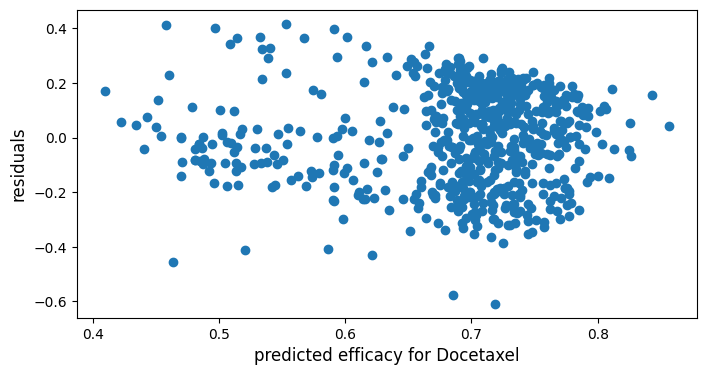

In [29]:
# Checking assumptions of linear regression satisfied: Residual plot and Homoscedasticity
# If the linear model is a good approximation, the residual plot should behave as a gaussian noise

# Here, the residual plot is for having 20 features selected from variance based approach
residuals_var = df_train_1.iloc[:,-1:] - ytrain_1

plt.figure(figsize=(8,4))
plt.scatter(ytrain_1, residuals_var)
plt.xlabel(f"predicted efficacy for {drug1}", fontsize=12)
plt.ylabel("residuals", fontsize=12)
plt.show()

# Clearly, not Gaussian noise. Heteroscedasticity --> Linear regression model is inappropriate. 
# Also, the RMSE for test set is even bigger than the standard deviation of the data.

# 4.2 SVM regression with RBF kernel

In [44]:
from sklearn.svm import SVR

# C: L2 Regularization parameter ~ 1/C: Reduce if overfitting
# epsilon: width of the tube
# gamma: can be included in poly, rbf
# Try linear first, then poly or rbf later if necessary

# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set
df_train_1, df_test_1 = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2)
df_train_2, df_test_2 = train_test_split(df_2, shuffle=True, random_state=42, test_size=.2)
df_train_3, df_test_3 = train_test_split(df_3, shuffle=True, random_state=42, test_size=.2)

svr_1 = SVR(kernel="linear", C=1, epsilon=0.1)
svr_2 = SVR(kernel="linear", C=1, epsilon=0.1)
svr_3 = SVR(kernel="linear", C=1, epsilon=0.1)

svr_1.fit(df_train_1[df_var.index], df_train_1.iloc[:,-1:].values.ravel())
svr_2.fit(df_train_2[df_var.index], df_train_2.iloc[:,-1:].values.ravel())
svr_3.fit(df_train_3[df_var.index], df_train_3.iloc[:,-1:].values.ravel())

# Calculate the RMSE
ytrain_1 = svr_1.predict(df_train_1[df_var.index])
ytrain_2 = svr_2.predict(df_train_2[df_var.index])
ytrain_3 = svr_3.predict(df_train_3[df_var.index])
train_svr_rmse_1 = RMSE(df_train_1.iloc[:,-1:], ytrain_1)
train_svr_rmse_2 = RMSE(df_train_2.iloc[:,-1:], ytrain_2)
train_svr_rmse_3 = RMSE(df_train_3.iloc[:,-1:], ytrain_3)

ytest_1 = svr_1.predict(df_test_1[df_var.index])
ytest_2 = svr_2.predict(df_test_2[df_var.index])
ytest_3 = svr_3.predict(df_test_3[df_var.index])
test_svr_rmse_1 = RMSE(df_test_1.iloc[:,-1:], ytest_1)
test_svr_rmse_2 = RMSE(df_test_2.iloc[:,-1:], ytest_2)
test_svr_rmse_3 = RMSE(df_test_3.iloc[:,-1:], ytest_3)

# Take square root for the MSE obtained from Scikit-Learn

print (f"RMSE for the training set for {drug1}", np.round(train_svr_rmse_1,3))
print (f"RMSE for the test set for {drug1}", np.round(test_svr_rmse_1,3))
print(f"sd in efficacy of {drug1}", df_1[drug1].std().round(3))
print("\n")

print (f"RMSE for the training set for {drug2}", np.round(train_svr_rmse_2,3))
print (f"RMSE for the test set for {drug2}", np.round(test_svr_rmse_2,3))
print(f"sd in efficacy of {drug2}", df_2[drug2].std().round(3))
print("\n")

print (f"RMSE for the training set for {drug3}", np.round(train_svr_rmse_3,3))
print (f"RMSE for the test set for {drug3}", np.round(test_svr_rmse_3,3))
print(f"sd in efficacy of {drug3}", df_3[drug3].std().round(3))

RMSE for the training set for Docetaxel 0.179
RMSE for the test set for Docetaxel 0.171
sd in efficacy of Docetaxel 0.192


RMSE for the training set for Trametinib 0.165
RMSE for the test set for Trametinib 0.213
sd in efficacy of Trametinib 0.186


RMSE for the training set for Entinostat 0.091
RMSE for the test set for Entinostat 0.105
sd in efficacy of Entinostat 0.105


# 4.3 XG Boost with Grid Search Hyperparameter tuning

In [45]:
# Install XG Boost packages to local kernel
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


4.3.1 For Docetaxel

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

df_train_1, df_test_1 = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2) # For Docetaxel

params = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10], # minimum number of instances needed to be in each node
    'gamma': [0.5, 1, 1.5], # minimum loss reduction required to make a further partition
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.05, 0.1, 0.25, 0.5]
}

# cv : number of k-fold cross validation

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

grid_search.fit(df_train_1[df_var.index], df_train_1.iloc[:,-1:])
print(f'Best parameters found: {grid_search.best_params_}')

best_params = grid_search.best_params_
model = xgb.XGBRegressor(objective ='reg:squarederror', **best_params)
model.fit(df_train_1[df_var.index], df_train_1.iloc[:,-1:])

# Prediction on training data
y_train_pred = model.predict(df_train_1[df_var.index])
train_rmse = np.round(RMSE(df_train_1.iloc[:,-1:], y_train_pred),3)

# Prediction on test data
y_test_pred = model.predict(df_test_1[df_var.index])
test_rmse = np.round(RMSE(df_test_1.iloc[:,-1:], y_test_pred),3)

print(f'Training RMSE for {drug1}: {train_rmse}')
print(f'Test RMSE for {drug1}: {test_rmse}')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
Training RMSE for Docetaxel: 0.175
Test RMSE for Docetaxel: 0.167


4.3.2 For Trametinib

In [20]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

df_train_2, df_test_2 = train_test_split(df_2, shuffle=True, random_state=42, test_size=.2) # For Trametinib

params = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10], # minimum number of instances needed to be in each node
    'gamma': [0.5, 1, 1.5], # minimum loss reduction required to make a further partition
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.25, 0.5, 0.75, 1.0]
}

# cv : number of k-fold cross validation

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

grid_search.fit(df_train_2[df_var.index], df_train_2.iloc[:,-1:])
print(f'Best parameters found: {grid_search.best_params_}')

best_params = grid_search.best_params_
model = xgb.XGBRegressor(objective ='reg:squarederror', **best_params)
model.fit(df_train_2[df_var.index], df_train_2.iloc[:,-1:])

# Prediction on training data
y_train_pred = model.predict(df_train_2[df_var.index])
train_rmse = np.round(RMSE(df_train_2.iloc[:,-1:], y_train_pred),3)

# Prediction on test data
y_test_pred = model.predict(df_test_2[df_var.index])
test_rmse = np.round(RMSE(df_test_2.iloc[:,-1:], y_test_pred),3)

print(f'Training RMSE for {drug2}: {train_rmse}')
print(f'Test RMSE {drug2}: {test_rmse}')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.75, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
Training RMSE for Trametinib: 0.159
Test RMSE Trametinib: 0.211


4.3.3 For Entinostat

In [23]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

df_train_3, df_test_3 = train_test_split(df_3, shuffle=True, random_state=42, test_size=.2) # For Entinostat

params = {
    'max_depth': [2, 3, 4],
    'min_child_weight': [1, 5, 10], # minimum number of instances needed to be in each node
    'gamma': [0.5, 1, 1.5], # minimum loss reduction required to make a further partition
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.1, 0.25, 0.5, 0.75]
}

# cv : number of k-fold cross validation

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

grid_search.fit(df_train_3[df_var.index], df_train_3.iloc[:,-1:])
print(f'Best parameters found: {grid_search.best_params_}')

best_params = grid_search.best_params_
model = xgb.XGBRegressor(objective ='reg:squarederror', **best_params)
model.fit(df_train_3[df_var.index], df_train_3.iloc[:,-1:])

# Prediction on training data
y_train_pred = model.predict(df_train_3[df_var.index])
train_rmse = np.round(RMSE(df_train_3.iloc[:,-1:], y_train_pred),3)

# Prediction on test data
y_test_pred = model.predict(df_test_3[df_var.index])
test_rmse = np.round(RMSE(df_test_3.iloc[:,-1:], y_test_pred),3)

print(f'Training RMSE for {drug3}: {train_rmse}')
print(f'Test RMSE for {drug3}: {test_rmse}')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.75, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.8}
Training RMSE for Entinostat: 0.094
Test RMSE for Entinostat: 0.109


# 4.4 Simple neural network using TensorFlow

In [52]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 1.3 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 1.0 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 993.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Drug 1: For Docetaxel

In [84]:
import tensorflow as tf

from tensorflow import keras
from keras import Model
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set
df_train_1, df_test_1 = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2) # For Docetaxel
df_train_2, df_test_2 = train_test_split(df_2, shuffle=True, random_state=42, test_size=.2) # For Trametinib
df_train_3, df_test_3 = train_test_split(df_3, shuffle=True, random_state=42, test_size=.2) # For Entinostat

scaler = make_column_transformer((StandardScaler(), df_var.index), remainder='passthrough')
scaler.fit(df_train_1)
scaler.transform(df_train_1)
scaler.transform(df_test_1)

# Try 2 hidden layer and same network for all 3 types of drugs

model = keras.models.Sequential([
    Dense(100,activation='relu'),
    Dense(50,activation='relu'),
    Dense(1, activation='linear')
])

# Use Adam optimizer, learning rate 0.005, RMSE for metrics

model.compile(loss = "mean_squared_error", optimizer = Adam(learning_rate=0.0005), metrics=['RootMeanSquaredError'])
history = model.fit(df_train_1[df_var.index], df_train_1.iloc[:,-1:], epochs=100)

y_pred_test1 = model1.predict(df_test_1[df_var.index])

print(f"RMSE for test set for {drug1}:", np.round(RMSE(df_test_1.iloc[:,-1:], y_pred_test1),3))

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - RootMeanSquaredError: 1.5165 - loss: 2.3713
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - RootMeanSquaredError: 0.7525 - loss: 0.5750
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - RootMeanSquaredError: 0.4932 - loss: 0.2438
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - RootMeanSquaredError: 0.4266 - loss: 0.1821
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - RootMeanSquaredError: 0.3925 - loss: 0.1542
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - RootMeanSquaredError: 0.3466 - loss: 0.1204
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - RootMeanSquaredError: 0.3444 - loss: 0.1187
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - RootMeanSquaredError: 0.3096 - loss: 0.0960
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - RootMeanSquaredError: 0.2991 - loss: 0.0896
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - RootMeanSquaredError: 0.2978 - loss: 0.0887
Epoch 11/

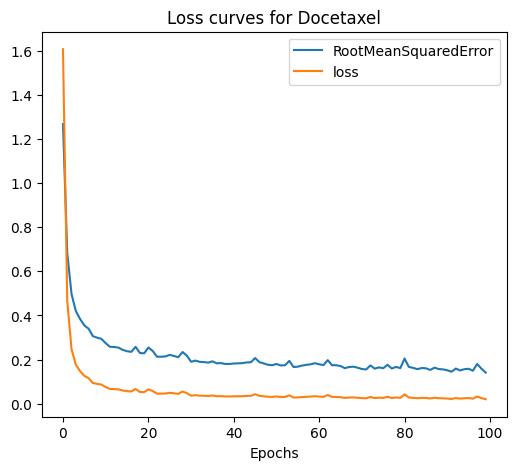

In [87]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.xlabel("Epochs")
plt.title(f'Loss curves for {drug1}')
plt.legend();

Drug 2: For Trametinib

In [89]:
# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set

df_train_2, df_test_2 = train_test_split(df_2, shuffle=True, random_state=42, test_size=.2) # For Trametinib

scaler = make_column_transformer((StandardScaler(), df_var.index), remainder='passthrough')
scaler.fit(df_train_2)
scaler.transform(df_train_2)
scaler.transform(df_test_2)

model = keras.models.Sequential([
    Dense(100,activation='relu'),
    Dense(50,activation='relu'),
    Dense(1, activation='linear')
])

# Use Adam optimizer, learning rate 0.005, RMSE for metrics

model.compile(loss = "mean_squared_error", optimizer = Adam(learning_rate=0.0005), metrics=['RootMeanSquaredError'])
history = model.fit(df_train_2[df_var.index], df_train_2.iloc[:,-1:], epochs=100)

y_pred_test2 = model.predict(df_test_2[df_var.index])

print(f"RMSE for test set for {drug2}:", np.round(RMSE(df_test_2.iloc[:,-1:], y_pred_test2),3))

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - RootMeanSquaredError: 1.2149 - loss: 1.5381
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - RootMeanSquaredError: 0.5538 - loss: 0.3078
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - RootMeanSquaredError: 0.3508 - loss: 0.1232
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - RootMeanSquaredError: 0.3055 - loss: 0.0934
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - RootMeanSquaredError: 0.2739 - loss: 0.0752
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - RootMeanSquaredError: 0.2629 - loss: 0.0693
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - RootMeanSquaredError: 0.2645 - loss: 0.0701
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - RootMeanSquaredError: 0.2272 - loss: 0.0517
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - RootMeanSquaredError: 0.2214 - loss: 0.0491
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - RootMeanSquaredError: 0.2025 - loss: 0.0413
Epoch 11/

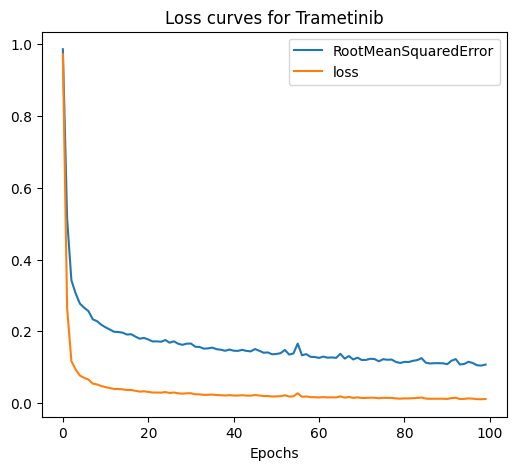

In [90]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.xlabel("Epochs")
plt.title(f'Loss curves for {drug2}')
plt.legend();

Drug 3: For Trametinib

In [91]:
# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set

df_train_3, df_test_3 = train_test_split(df_3, shuffle=True, random_state=42, test_size=.2) # For Trametinib

scaler = make_column_transformer((StandardScaler(), df_var.index), remainder='passthrough')
scaler.fit(df_train_3)
scaler.transform(df_train_3)
scaler.transform(df_test_3)

model = keras.models.Sequential([
    Dense(100,activation='relu'),
    Dense(50,activation='relu'),
    Dense(1, activation='linear')
])

# Use Adam optimizer, learning rate 0.005, RMSE for metrics

model.compile(loss = "mean_squared_error", optimizer = Adam(learning_rate=0.0005), metrics=['RootMeanSquaredError'])
history = model.fit(df_train_3[df_var.index], df_train_3.iloc[:,-1:], epochs=100)

y_pred_test3 = model.predict(df_test_3[df_var.index])

print(f"RMSE for test set for {drug3}:", np.round(RMSE(df_test_3.iloc[:,-1:], y_pred_test3),3))

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - RootMeanSquaredError: 1.9609 - loss: 4.0705 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - RootMeanSquaredError: 0.6539 - loss: 0.4299
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - RootMeanSquaredError: 0.4101 - loss: 0.1682
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - RootMeanSquaredError: 0.3483 - loss: 0.1214
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - RootMeanSquaredError: 0.3157 - loss: 0.0998
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - RootMeanSquaredError: 0.2828 - loss: 0.0800
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - RootMeanSquaredError: 0.2489 - loss: 0.0620
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - RootMeanSquaredError: 0.2436 - loss: 0.0595
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - RootMeanSquaredError: 0.2244 - loss: 0.0504
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - RootMeanSquaredError: 0.2157 - loss: 0.0466
Epoch 11

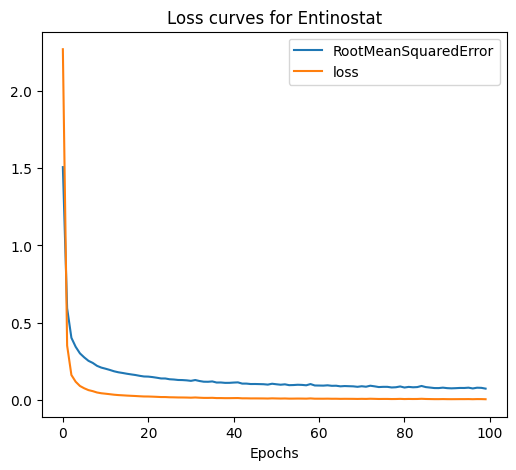

In [92]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.xlabel("Epochs")
plt.title(f'Loss curves for {drug3}')
plt.legend();